In [1]:
import distutils.util
import os
import subprocess

In [2]:
import mujoco
mujoco.MjModel.from_xml_string('<mujoco/>')

In [3]:
import time
import itertools
import numpy as np

In [4]:
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

xml形式でモデルをもつ

In [148]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# 赤い箱と緑の球
model = mujoco.MjModel.from_xml_string(xml)

In [150]:
#ジオメトリの数
model.ngeom

2

In [151]:
# ジオメトリの持つ色のリスト
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

In [152]:
#ジオメトリ毎のプロパティ
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

In [153]:
#初期化時に値を指定してないパラメタは適当な初期値が入ってるっぽい
model.geom("red_box")

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 0
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'red_box'
  pos: array([0., 0., 0.])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.346])
  rgba: array([1., 0., 0., 1.], dtype=float32)
  sameframe: array([1], dtype=uint8)
  size: array([0.2, 0.2, 0.2])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([6], dtype=int32)
  user: array([], dtype=float64)
>

In [154]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

In [155]:
# 名前からIDを取得する事も出来る
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

In [156]:
# 剛体の名前一覧を得る方法
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

mjDataクラスで、時間とそれに依存する一般化座標と一般化速度を持つ
それぞれ、data.time、data.qpos、data.qvel

In [27]:
data = mujoco.MjData(model)
print(data.time, data.qpos, data.qvel)

0.0 [] []


mjDataは世界座標系のオブジェクト位置も持ってるが、FKを解かなければちゃんとした値は持ってない

In [28]:
# 緑球のオフセットが入ってない
data.geom_xpos

array([[0., 0., 0.],
       [0., 0., 0.]])

In [29]:
mujoco.mj_kinematics(model, data) #キネマ解く
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# レンダリング

""

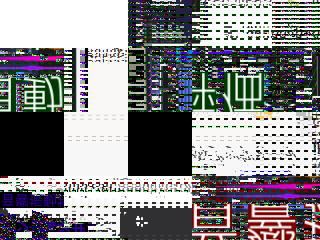

In [30]:
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  media.show_image(renderer.render())

黒いピクセルはなぜ？

答えは 上記と同じ理由で、まずmjDataの値を伝播させる必要があります。つまり、x˙=f(x)を計算する。ここでxは状態である。この関数は実際に必要な以上のことをしますが、計算時間を節約することを気にしない限り、mj_forwardを呼び出すのは良い方法です。

また、ビジュアル・シーンを記述するレンダラーが保持するオブジェクトであるmjvSceneを更新する必要もある。シーンには、物理モデルの一部ではないビジュアル・オブジェクトを含めることができることを後で説明します。

""

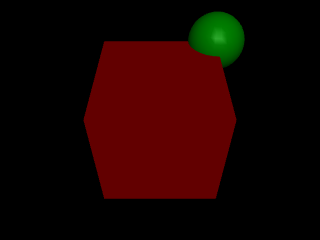

In [157]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

""

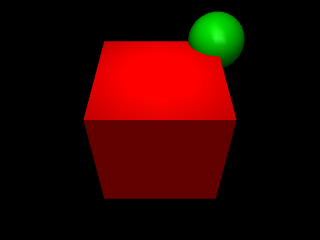

In [158]:
# xml弄って、光源の位置を調整
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

""

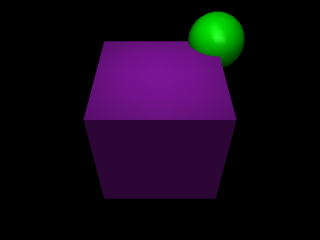

In [159]:
# 箱の色をランダムに変更
model.geom('red_box').rgba[:3] = np.random.rand(3)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [160]:
# 動画の生成
def make_video(model, data, duration, height = 240, width = 320, scene_option=None, camera=-1):
    frames = []
    with mujoco.Renderer(model, height, width) as renderer:
      while data.time < duration:
        mujoco.mj_step(model, data)#時間を進める
        if len(frames) < data.time * framerate:
            # １枚づつとってフィルムに収めるかんじ
          renderer.update_scene(data, scene_option=scene_option, camera=camera)
          pixels = renderer.render()
          frames.append(pixels)
    return frames
duration = 3.8  # (seconds)
framerate = 60  # (Hz)
mujoco.mj_resetData(model, data)  #状態を初期化
frames = make_video(model, data, duration)
media.show_video(frames, fps=framerate)#動画の描写

In [103]:
# 回転関節を加えてみる
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# 関節を見せるオプションをTrueにしないと関節は見えない
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
mujoco.mj_resetData(model, data)
frames = make_video(model, data, duration, scene_option=scene_option)
media.show_video(frames, fps=framerate)

In [104]:
model.opt.timestep

0.002

In [105]:
print('default gravity', model.opt.gravity)
#重力を反対に働かせて遊ぶ
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
frames = make_video(model, data, duration, scene_option=scene_option)
media.show_video(frames, fps=60)

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


In [106]:
#なんか状態量の値とか見てみる
print('モデル中の関節自由度の数:', model.nv)
print('Time:', data.time)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

モデル中の関節自由度の数: 1
Time: 3.801999999999803
Generalized positions: [1.392]
Generalized velocities: [-3.79]


- <option/>で積分器を4次のルンゲクッタに設定（精度がいいらしい）
- <freejoint/>で6DoFのフリージョイントを追加する。
- <asset/>で床のグリッドマテリアル（見た目）を定義し、それを "plane"geomで参照する
    
- トップの重心を低くするために、"ballast"という不可視で非衝突のgeomを使用します。重心を低くすることは、（直感に反しますが）反転の動作に必要
- 回転状態からシミュレーションを始めるためにkeyframeを保存する
    - Z軸周りの速い回転速度にプラスしてY軸周りの遅い回転を混ぜて、わざとこかせる
<camera>を定義し、update_scene()のcamera引数に名前を渡す

""

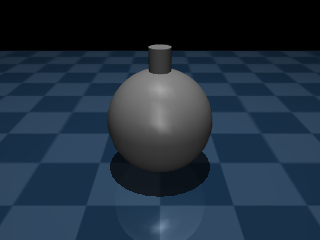

In [122]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, camera="closeup")

  media.show_image(renderer.render())

In [123]:
print('positions', data.qpos)
print('velocities', data.qvel)
#姿勢はクオータニオン表現なのでpositionが七次元になってること注意

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


0

In [134]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, model.keyframe("spinning").id) # "spinnig"のキーフレームで初期化
frames = make_video(model, data, duration, camera="closeup")
media.show_video(frames, fps=framerate)

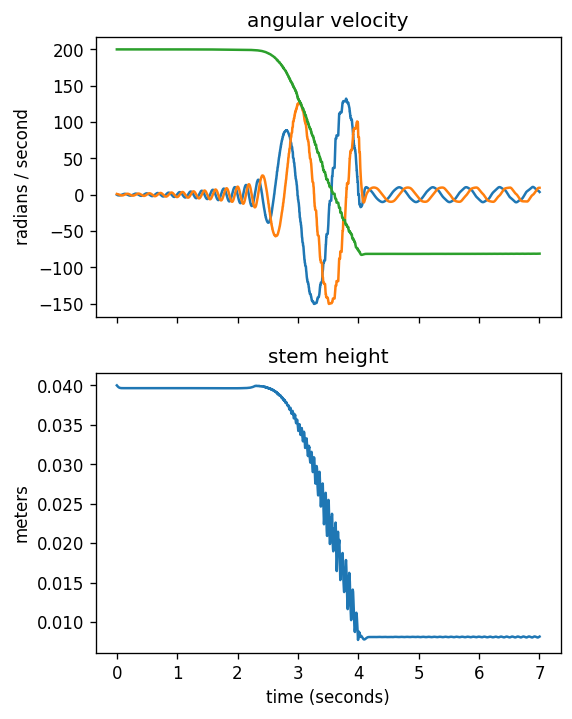

In [135]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, model.keyframe("spinning").id)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2]);

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

- <default>でjointやgeomのローカル設定が作れるっぽい
    - ここでは、jointはヒンジタイプと回転軸の設定、geomはカプセルタイプで、、、みたいな事を決めてる
- カメラを真横からにしてる

""

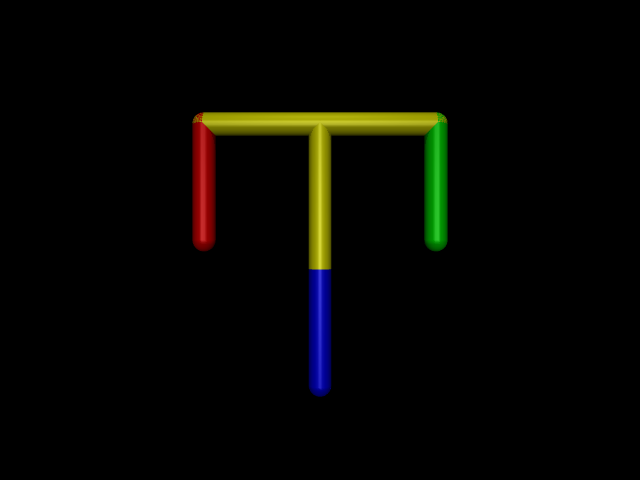

In [138]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
# 画像大きめに
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

シミュレーションとレンダリングにそれぞれどれくらい計算時間がかかっているかを計算

In [140]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  8.08 μs/step  (123822Hz)
rendering:  1.5e+03 μs/frame (  666Hz)




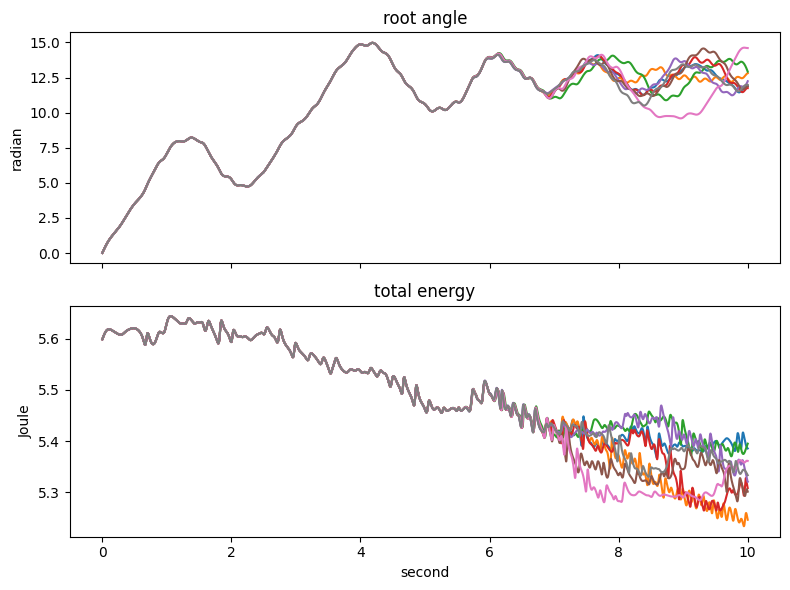

In [145]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos[0]
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

In [146]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
